In [1]:
#Подклюбчаем нужные библиотеки
import pandas as pd
import numpy as np
import torch
import string
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel

In [2]:
#Опишем класс обработки текста
class TextPreparetion:

    def __init__(self):
        self.punctuation_translater = str.maketrans('', '', string.punctuation)
        self.part_speech_words = ['а', 'в', 'но', 'и', 'не', 'из', 'под']

    def punctuation_delete(self, iText):
        return iText.translate(self.punctuation_translater)

    def part_speech_delete(self, iText):
        query_words = iText.split()
        result_words  = [word for word in query_words if word.lower() not in self.part_speech_words]
        return ' '.join(result_words)

#Опишем класс для семантического поиска
class SemanticSearch:

    def __init__(self, iModel_name):
        self.tokenizer = AutoTokenizer.from_pretrained(iModel_name)
        self.model = AutoModel.from_pretrained(iModel_name)
        self.textPreparetion = TextPreparetion()
    
    #Метод поиска
    def search(self, iDocument, iWord):
        #Делим текст на пары
        segmentation_document = self.__prepare_document__(iDocument)
        #Собираем словарь сровнения пар с таргетом
        segment_probabilities = self.__compare_list_embeddings_(iWord, segmentation_document)
        #Получаем сегмент с наилучшим сходством
        best_similar_segment = self.__get_key_max_similar__(segment_probabilities)
        
        #Если лучшее решение меньше 67% точности, то считаем что ничего не нашли
        if segment_probabilities[best_similar_segment] <= 0.67:
            return '', 1 - segment_probabilities[best_similar_segment]

        #В паре слов проверим каждое слово
        word_probabilities = self.__compare_list_embeddings_(iWord, best_similar_segment.split(' '))
        #Получаем слово с наилучшим сходством
        best_similar_word = self.__get_key_max_similar__(word_probabilities)

        #Проверяем что лучше сегмент или слово
        if segment_probabilities[best_similar_segment] > word_probabilities[best_similar_word]:
            return best_similar_segment, segment_probabilities[best_similar_segment]
        else:
            return best_similar_word, word_probabilities[best_similar_word]

    #Метод сегментации документа на пары слов
    def __prepare_document__(self, iDocument):
        #Удалим знаки препинания
        document = self.textPreparetion.punctuation_delete(iDocument)
        #Удалим служебные части речи
        document = self.textPreparetion.part_speech_delete(document)
        
        words_list = document.split()
        segmentation_document = list()

        for index in range(len(words_list)):
            #Добавляем пару слов
            if index != len(words_list) - 1:
                segmentation_document.append(
                    words_list[index] + ' ' + words_list[index + 1]
                )
                
        if len(segmentation_document) == 0:
            segmentation_document.append(words_list[0])
            
        return(segmentation_document)

    #Метод получения векторного представления текста 
    def __get_bert_embedding__(self, iText):
        inputs = self.tokenizer(iText, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()
    
    def __compare_list_embeddings_(self, iTarget_text, iTexsts_list):
        probabilities = dict()
        
        #Переврдим в векторное представление целевой текст
        target_embedding = self.__get_bert_embedding__(iTarget_text)

        #Составляем словарь с вероятностями совпадений
        for segmrnt_text in iTexsts_list:
            segment_embedding = self.__get_bert_embedding__(segmrnt_text)
            similarity = cosine_similarity(target_embedding, segment_embedding)[0][0]
            probabilities[segmrnt_text] = similarity

        return probabilities
    
    #Метод для получения индекса слова максимального совпадения
    def __get_key_max_similar__(self, iProbabilities):

        if len(iProbabilities) == 1:
            return list(iProbabilities.keys())[0]
        else:
            return max(iProbabilities, key=iProbabilities.get)

In [3]:
#Прочитаем датасет с тестом
test_df = pd.read_csv('TestDataSet.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   исходный_текст   100 non-null    object
 1   текст_поиска     100 non-null    object
 2   найденный_текст  86 non-null     object
dtypes: object(3)
memory usage: 2.5+ KB


In [4]:
#Обработаем датасет

#Заполним пропуски пробелом
test_df.fillna('', inplace=True)

#Удалим все знаки препинания и переведем в нижний регистр
translator = str.maketrans('', '', string.punctuation)

test_df['исходный_текст'] = test_df['исходный_текст'].map(lambda s: s.translate(translator).lower())
test_df['текст_поиска'] = test_df['текст_поиска'].map(lambda s: s.translate(translator).lower())
test_df['найденный_текст'] = test_df['найденный_текст'].map(lambda s: s.translate(translator).lower())

In [5]:
#Составим список пред обученных моделей
model_names = [
    'intfloat/multilingual-e5-base',
    'Alibaba-NLP/gte-multilingual-base',
    'deepvk/USER-bge-m3'
]

In [6]:
#Протестируем все модели
for model_name in model_names:
    semanticSearch = SemanticSearch(model_name)
    
    result_field_name = f'{model_name}_result'
    prob_field_name = f'{model_name}_prob'
    test_df[result_field_name] = ''
    test_df[prob_field_name] = 0.0
    
    for index, row in test_df.iterrows():
        word, prob = semanticSearch.search(row['исходный_текст'], row['текст_поиска'])
        test_df.at[index, result_field_name] = word
        test_df.at[index, prob_field_name] = prob

The repository for Alibaba-NLP/gte-multilingual-base contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/Alibaba-NLP/gte-multilingual-base.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y
The repository for Alibaba-NLP/gte-multilingual-base contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/Alibaba-NLP/gte-multilingual-base.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
display(test_df)

,исходный_текст,текст_поиска,найденный_текст,intfloat/multilingual-e5-base_result,intfloat/multilingual-e5-base_prob,Alibaba-NLP/gte-multilingual-base_result,Alibaba-NLP/gte-multilingual-base_prob,deepvk/USER-bge-m3_result,deepvk/USER-bge-m3_prob
0,солнце медленно скрылось за горизонтом оставив...,горизонт,горизонтом,горизонтом,0.956458,горизонтом,0.968899,горизонтом,0.931469
1,в старом сарае нашли ржавый велосипед покрытый...,амбар,сарае,сарае,0.855344,нашли ржавый,0.761478,,0.389791
2,кофе остыл но она всё ещё держала чашку глядя ...,стакан,чашку,чашку,0.937574,чашку,0.920402,чашку,0.834543
3,дождь начался внезапно заставив прохожих искат...,ливень,дождь,дождь,0.911906,дождь,0.911586,дождь,0.881833
4,дети смеялись бегая по лужам не обращая вниман...,вода,,внимания,0.860934,лужам,0.828074,,0.350309
...,...,...,...,...,...,...,...,...,...
95,в пруду плавала утка с утятами и люди бросали ...,гусь,,хлеб,0.843191,утка,0.803934,,0.352911
96,она завязала волосы в хвост но через минуту он...,прядь,волосы,волосы,0.890509,волосы,0.839200,завязала,0.703813
97,на крыльце сидел рыжий кот и вылизывал лапу,веранда,крыльце,крыльце,0.849253,на,0.764740,,0.349306
98,он достал из кармана монету и подбросил её но ...,металлические деньги,монету,монету,0.868631,монету,0.876645,монету,0.782918


Составим словарь result в котором ключ - название модели, а значение - датафрейм с данными модели.</br>
Далее для каждой модели посчитаем количество правильных ответов и ложные срабатывания.</br>
Точностиь модели (accuracy) будет определяться как количество правильных ответов / на общее количесто ответов</br>
Ложное срабатывание - это положительный результат поиска там, где его не должно быть. Расчитывается как количество найденных текстов / количество текстов с пропусками

In [8]:
#Обработаем результаты и соберем словарь
result = dict()

for model_name in model_names:
    temp_df = pd.DataFrame()

    result_field_name = f'{model_name}_result'
    prob_field_name = f'{model_name}_prob'

    temp_df['найденный_текст'] = test_df['найденный_текст']
    temp_df[result_field_name] = test_df[result_field_name]
    temp_df[prob_field_name] = test_df[prob_field_name]
    temp_df['correct'] = temp_df['найденный_текст'] == temp_df[result_field_name]
    temp_df['FP'] = np.logical_and( temp_df['найденный_текст'] == '', temp_df[result_field_name] != '' )

    result[model_name] = temp_df
    

In [18]:
accuracy_list = list()

for model_name in model_names:
    accuracy_list.append( round( sum(result[model_name]['correct']) / result[model_name].shape[0], 2 ))

chart_data = {
    'model_name': model_names,
    'accuracy': accuracy_list
}

chart_df = pd.DataFrame(chart_data)
display(chart_df)

,model_name,accuracy
0,intfloat/multilingual-e5-base,0.58
1,Alibaba-NLP/gte-multilingual-base,0.61
2,deepvk/USER-bge-m3,0.48


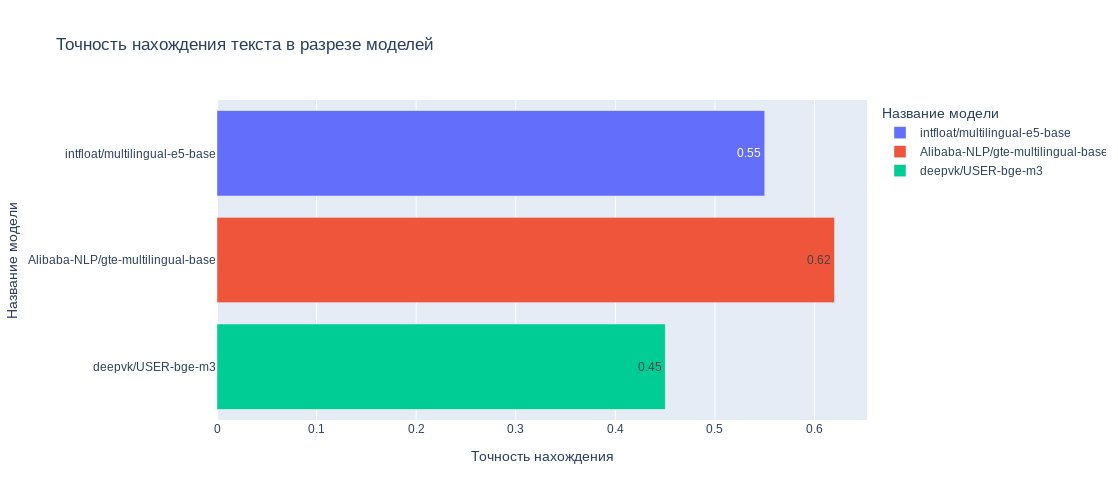

In [11]:
fig = px.bar(
    data_frame=chart_df,
    x="accuracy",
    y="model_name",
    color='model_name',
    text = 'accuracy',
    orientation='h',
    height=500,
    width=1000,
    title='Точность нахождения текста в разрезе моделей',
    labels={'accuracy': 'Точность нахождения', 'model_name':'Название модели'}
)
fig.show()

#Сохранить интерактиынвй график
fig.write_html("accuracy.html")

In [32]:
fp_list = list()

fp_data = result[model_name][
    result[model_name]['найденный_текст'] == ''
]
print(f'количество текстов в которых поиск должен быть пустым: {fp_data.shape[0]}')

for model_name in model_names:
    fp_list.append( round( sum(result[model_name]['FP']) / fp_data.shape[0], 2 ))

chart_data = {
    'model_name': model_names,
    'fp': fp_list
}

chart_df = pd.DataFrame(chart_data)
display(chart_df)

количество текстов в которых поиск должен быть пустым: 14


,model_name,fp
0,intfloat/multilingual-e5-base,1.00
1,Alibaba-NLP/gte-multilingual-base,1.00
2,deepvk/USER-bge-m3,0.57


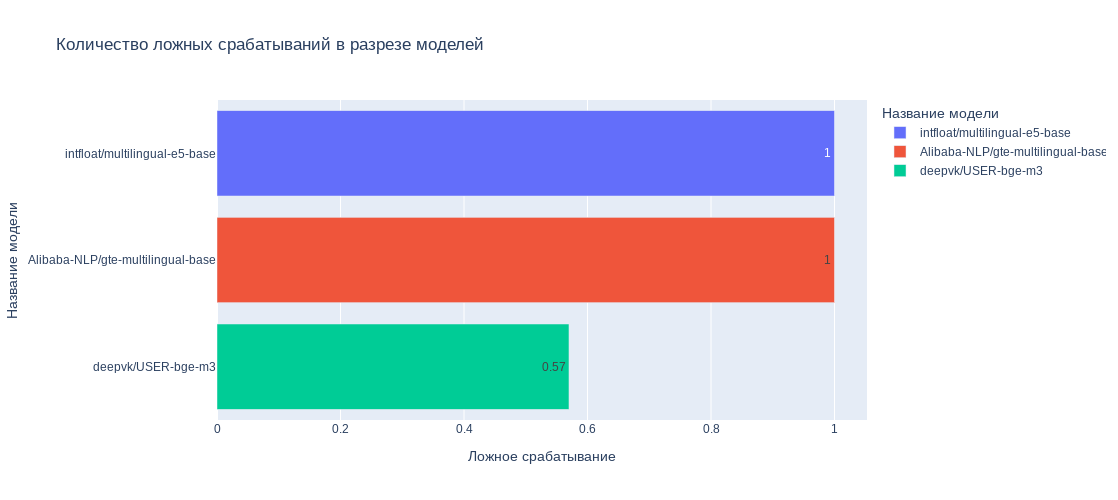

In [31]:
fig = px.bar(
    data_frame=chart_df,
    x="fp",
    y="model_name",
    color='model_name',
    text = 'fp',
    orientation='h',
    height=500,
    width=1000,
    title='Количество ложных срабатываний в разрезе моделей',
    labels={'fp': 'Ложное срабатывание', 'model_name':'Название модели'}
)
fig.show()

#Сохранить интерактиынвй график
fig.write_html("fp.html")